In [ ]:
# Importing essential libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing specific modules from libraries
from torchvision import transforms
from os import path
from scipy.ndimage import rotate
from torch import nn
from sklearn.metrics import confusion_matrix

# Importing utility modules
import random
from torch.utils.data import Dataset, DataLoader, sampler
from copy import deepcopy
import nibabel as nib

In [ ]:
!wget --show-progress --verbose --tries=3 --no-check-certificate https://aramislab.paris.inria.fr/files/data/databases/DL4MI/OASIS-1-dataset_pt_new.tar.gz

--2024-06-01 16:15:51--  https://aramislab.paris.inria.fr/files/data/databases/DL4MI/OASIS-1-dataset_pt_new.tar.gz
Resolving aramislab.paris.inria.fr (aramislab.paris.inria.fr)... 128.93.101.235
Connecting to aramislab.paris.inria.fr (aramislab.paris.inria.fr)|128.93.101.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1387416064 (1.3G) [application/octet-stream]
Saving to: ‘OASIS-1-dataset_pt_new.tar.gz’

OASIS-1-dataset_pt_ 100%[===================>]   1.29G  7.02MB/s    in 2m 12s  

2024-06-01 16:18:04 (10.0 MB/s) - ‘OASIS-1-dataset_pt_new.tar.gz’ saved [1387416064/1387416064]



In [ ]:
! tar xf OASIS-1-dataset_pt_new.tar.gz -C ./

   participant_id session_id alternative_id_1 sex  education_level  age_bl  \
0  sub-OASIS10001    ses-M00    OAS1_0001_MR1   F              2.0      74   
1  sub-OASIS10002    ses-M00    OAS1_0002_MR1   F              4.0      55   
2  sub-OASIS10003    ses-M00    OAS1_0003_MR1   F              4.0      73   
3  sub-OASIS10004    ses-M00    OAS1_0004_MR1   M              NaN      28   
4  sub-OASIS10005    ses-M00    OAS1_0005_MR1   M              NaN      18   

  diagnosis_bl laterality   MMS  cdr_global diagnosis  
0           CN          R  29.0         0.0        CN  
1           CN          R  29.0         0.0        CN  
2           AD          R  27.0         0.5        AD  
3           CN          R  30.0         NaN        CN  
4           CN          R  30.0         NaN        CN  


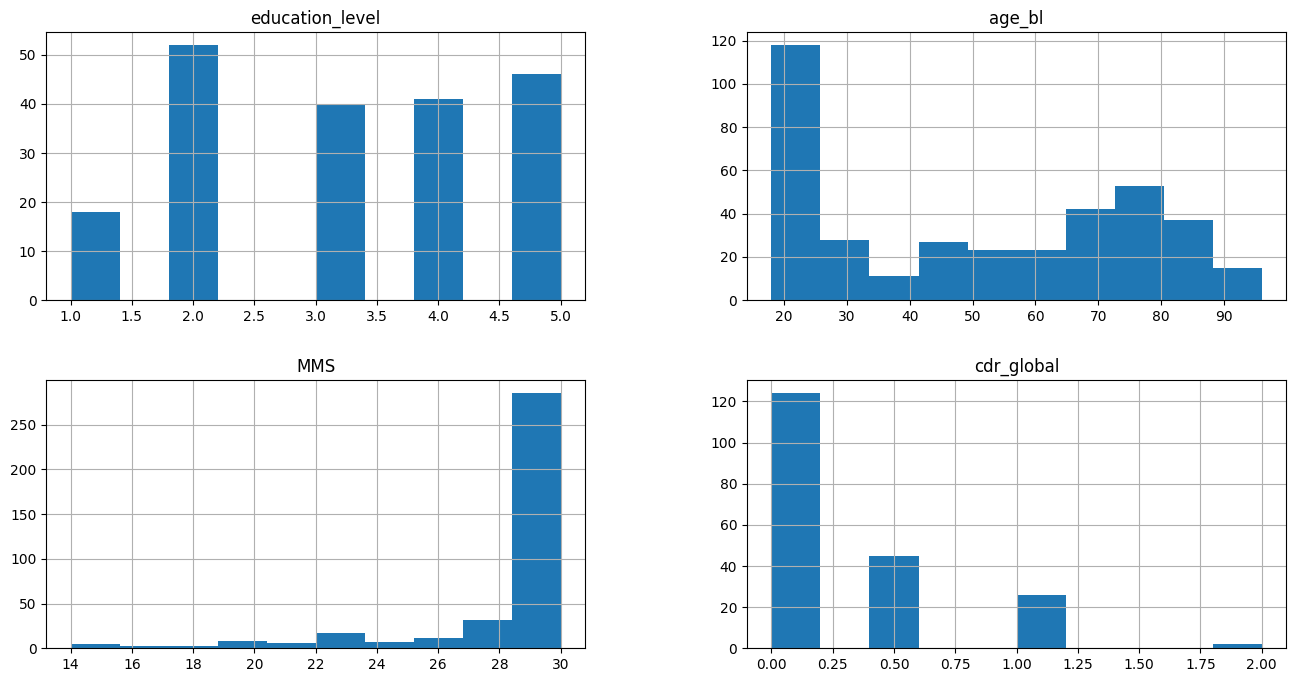

In [ ]:
# File path
file_path = 'OASIS-1_dataset/tsv_files/lab_1/OASIS_BIDS.tsv'

# Columns to load
columns_to_load = [
    'participant_id', 'session_id', 'alternative_id_1', 'sex',
    'education_level', 'age_bl', 'diagnosis_bl', 'laterality', 'MMS',
    'cdr_global', 'diagnosis']

# Read the CSV file using pandas of dataset
df_data = pd.read_csv(file_path, sep='\t', usecols=columns_to_load)
# Show first five items of the table
print(df_data.head())
# First visual inspection
_ = df_data.hist(figsize=(16, 8))

In [ ]:
class ds_MRI(Dataset):

    def __init__(self, image_directory, df_dataset, list_transforms=None):

        self.image_directory = image_directory
        self.list_transforms = list_transforms
        self.df_dataset = df_dataset
        self.diagnostic_code = {"AD": 1, "CN": 0}
        # Set the size attribute based on the shape of the first image in the dataset
        if len(self.df_dataset) > 0:
            self.size = self.__getitem__(0)['image'].shape
        else:
            raise ValueError("The dataset is empty, cannot determine image shape.")

    def __len__(self):
        return len(self.df_dataset)

    def __getitem__(self, idx):

        diag_stage = self.df_dataset.loc[idx, 'diagnosis']
        diagnosis_label = self.diagnostic_code[diag_stage]

        patient_id = self.df_dataset.loc[idx, 'participant_id']
        assignment_id = self.df_dataset.loc[idx, 'session_id']
        patient_file = (
            f'subjects/{patient_id}/{assignment_id}/'
            f'deeplearning_prepare_data/image_based/custom/'
            f'{patient_id}_{assignment_id}_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability.pt'
        )

        patient_image = torch.load(path.join(self.image_directory, patient_file))

        if self.list_transforms:
            patient_image = self.list_transforms(patient_image)

        sample = {'image': patient_image, 'label': diagnosis_label,
                  'participant_id': patient_id,
                  'session_id': assignment_id}
        return sample

    def train(self):
        self.list_transforms.train()

    def eval(self):
        self.list_transforms.eval()

In [ ]:

class CropRightHippoCampus(object):
    """Crops the right hippocampus of a MRI"""

    def __init__(self, rndm_move=0):
        self.rndm_move = rndm_move
        self.training_mode = True

    def __call__(self, img):
        if self.training_mode:
            x_dir = random.randint(-self.rndm_move, self.rndm_move)
            y_dir = random.randint(-self.rndm_move, self.rndm_move)
            z_dir = random.randint(-self.rndm_move, self.rndm_move)
        else:
            x_dir, y_dir, z_dir = 0, 0, 0

        # Calculate the indices for cropping
        x_start, x_end = 65 + x_dir, 95 + x_dir
        y_start, y_end = 50 + y_dir, 90 + y_dir
        z_start, z_end = 27 + z_dir, 57 + z_dir

        # Perform the crop and clone the resulting tensor
        return img[:, x_start:x_end, y_start:y_end, z_start:z_end].clone()

    def train(self):
        self.training_mode = True

    def eval(self):
        self.training_mode = False

In [ ]:
ds_train = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/train.tsv', sep='\t')
ds_test = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/validation.tsv', sep='\t')

class PadMaxPool3d(nn.Module):

    def __init__(self, kernel_size, stride, return_indices=False, return_pad=False):
            super().__init__()
            self.kernel_size = kernel_size
            self.stride = stride
            self.return_indices = return_indices
            self.return_pad = return_pad

            # Initialize the pooling and padding layers
            self.pool = nn.MaxPool3d(kernel_size=kernel_size, stride=stride, return_indices=return_indices)
            self.pad = nn.ConstantPad3d(padding=0, value=0)

    def forward(self, temp_map):
        coords = []
        for i in range(3):
            size = temp_map.size(i + 2)
            remainder = size % self.stride
            adjustment = self.stride - remainder
            coords.append(adjustment)

        coords = [0 if coord == self.stride else coord for coord in coords]

        self.pad.padding = (coords[2], 0, coords[1], 0, coords[0], 0)

        if self.return_indices:
            output, indices = self.pool(self.pad(temp_map))

            if self.return_pad:
                padding_info = (coords[2], 0, coords[1], 0, coords[0], 0)
                return output, indices, padding_info
            else:
                return output, indices

        else:
            output = self.pool(self.pad(temp_map))

            if self.return_pad:
                padding_info = (coords[2], 0, coords[1], 0, coords[0], 0)
                return output, padding_info
            else:
                return output

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        current_channels = in_channels
        for i in range(num_layers):
            layer = nn.Sequential(
                nn.BatchNorm3d(current_channels),
                nn.ReLU(inplace=True),
                nn.Conv3d(current_channels, growth_rate, kernel_size=3, padding=1, bias=False),
                nn.Dropout3d(0.2)
            )
            self.layers.append(layer)
            current_channels += growth_rate

    def forward(self, x):
        for layer in self.layers:
            new_features = layer(x)
            x = torch.cat([x, new_features], 1)
        return x

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.downsample = nn.Sequential(
            nn.BatchNorm3d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.AvgPool3d(2, stride=2)
        )

    def forward(self, x):
        return self.downsample(x)

class DenseNet3D(nn.Module):
    def __init__(self):
        super(DenseNet3D, self).__init__()
        growth_rate = 16
        num_blocks = [6, 12, 32, 32]  # Example configuration of layers in each block
        num_init_features = 16
        compression_factor = 0.5

        self.initial_conv = nn.Conv3d(1, num_init_features, kernel_size=3, padding=1)

        # Dense blocks and transition layers
        num_features = num_init_features
        self.blocks = nn.ModuleList()
        for i, num_layers in enumerate(num_blocks):
            block = DenseBlock(num_layers, num_features, growth_rate)
            self.blocks.append(block)
            num_features += num_layers * growth_rate

            if i != len(num_blocks) - 1:
                out_features = int(num_features * compression_factor)
                transition = TransitionLayer(num_features, out_features)
                self.blocks.append(transition)
                num_features = out_features

        # Final batch normalization and classifier
        self.final_bn = nn.BatchNorm3d(num_features)
        self.global_pool = nn.AdaptiveAvgPool3d(1)
        self.classifier = nn.Linear(num_features, 2)

    def forward(self, x):
        x = self.initial_conv(x)
        for block in self.blocks:
            x = block(x)
        x = F.relu(self.final_bn(x))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
import torch.nn as nn

def train(model, train_loader, criterion, optimizer, n_epochs):

    best_model = deepcopy(model)
    best_loss = np.inf

    for epoch in range(n_epochs):
        model.train()
        train_loader.dataset.train()

        for i, data in enumerate(train_loader, 0):
            # Retrieve mini-batch and put data on GPU with .cuda()
            images = data['image'].cuda()
            labels = data['label'].cuda()
            # Forward pass
            outputs = model(images)
            # Loss computation
            loss = criterion(outputs, labels)
            # Back-propagation (gradients computation)
            loss.backward()
            # Parameters update
            optimizer.step()
            # Erase previous gradients
            optimizer.zero_grad()

        _, train_metrics = test(model, train_loader, criterion)

        print(
            f"Epoch {epoch}: loss = {train_metrics['mean_loss']:.4f}, "
            f"balanced accuracy = {train_metrics['balanced_accuracy']:.4f}"
        )

        if train_metrics['mean_loss'] < best_loss:
            best_model = deepcopy(model)
            best_loss = train_metrics['mean_loss']

    return best_model

def test(model, data_loader, criterion):

    model.eval()
    data_loader.dataset.eval()
    columns = ["participant_id", "proba0", "proba1", "true_label", "predicted_label"]
    final_df = pd.DataFrame(columns=columns)
    total_loss = 0

    # Disable gradient computation for validation/testing
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            # Move images and labels to GPU
            images = data['image'].cuda()
            labels = data['label'].cuda()
            # Forward pass: compute predicted outputs
            outputs = model(images)
            # Compute the loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            # Compute probabilities using Softmax
            probs = nn.Softmax(dim=1)(outputs)
            # Get the predicted class with the highest probability
            _, predicted = torch.max(outputs.data, 1)
            # Prepare data for the results DataFrame
            rows = [
                [
                    data['participant_id'][idx],
                    probs[idx, 0].item(),
                    probs[idx, 1].item(),
                    labels[idx].item(),
                    predicted[idx].item()
                ]
                for idx in range(len(data['participant_id']))
            ]

            # Create a DataFrame from the rows and concatenate to the results DataFrame
            batch_df = pd.DataFrame(rows, columns=columns)
            final_df = pd.concat([final_df, batch_df], ignore_index=True)

    # Convert the true_labels and predicted_labels to integers

    true_labels = final_df['true_label'].to_numpy(dtype=int)
    predicted_labels = final_df['predicted_label'].to_numpy(dtype=int)

    # Print unique values and types for debugging
    print("True labels unique values:", np.unique(true_labels), "Type:", true_labels.dtype)
    print("Predicted labels unique values:", np.unique(predicted_labels), "Type:", predicted_labels.dtype)

    # Compute metrics for true and predicted labels
    final_metrics = compute_metrics(true_labels, predicted_labels)

    # Reset the index of the results DataFrame
    final_df.reset_index(drop=True, inplace=True)

    # Calculate mean loss and add it to the results metrics
    mean_loss = total_loss / len(data_loader.dataset)
    final_metrics['mean_loss'] = mean_loss

    return final_df, final_metrics

def compute_metrics(ground_truth, prediction):
    """Computes the accuracy, sensitivity, specificity, balanced accuracy, and confusion matrix"""
    # Ensure that ground_truth and prediction are numpy arrays
    ground_truth = np.array(ground_truth)
    prediction = np.array(prediction)

    # Compute confusion matrix
    cm = confusion_matrix(ground_truth, prediction)

    true_positives = np.sum((prediction == 1) & (ground_truth == 1))
    true_negatives = np.sum((prediction == 0) & (ground_truth == 0))
    false_positives = np.sum((prediction == 1) & (ground_truth == 0))
    false_negatives = np.sum((prediction == 0) & (ground_truth == 1))

    metrics_dict = dict()
    metrics_dict['accuracy'] = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

    # Sensitivity
    if true_positives + false_negatives != 0:
        metrics_dict['sensitivity'] = true_positives / (true_positives + false_negatives)
    else:
        metrics_dict['sensitivity'] = 0.0

    # Specificity
    if false_positives + true_negatives != 0:
        metrics_dict['specificity'] = true_negatives / (false_positives + true_negatives)
    else:
        metrics_dict['specificity'] = 0.0

    metrics_dict['balanced_accuracy'] = (metrics_dict['sensitivity'] + metrics_dict['specificity']) / 2
    metrics_dict['confusion_matrix'] = cm

    # Print the confusion matrix
    print("Confusion Matrix:\n", cm)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return metrics_dict

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [1] Type: int64
Confusion Matrix:
 [[  0 242]
 [  0  58]]


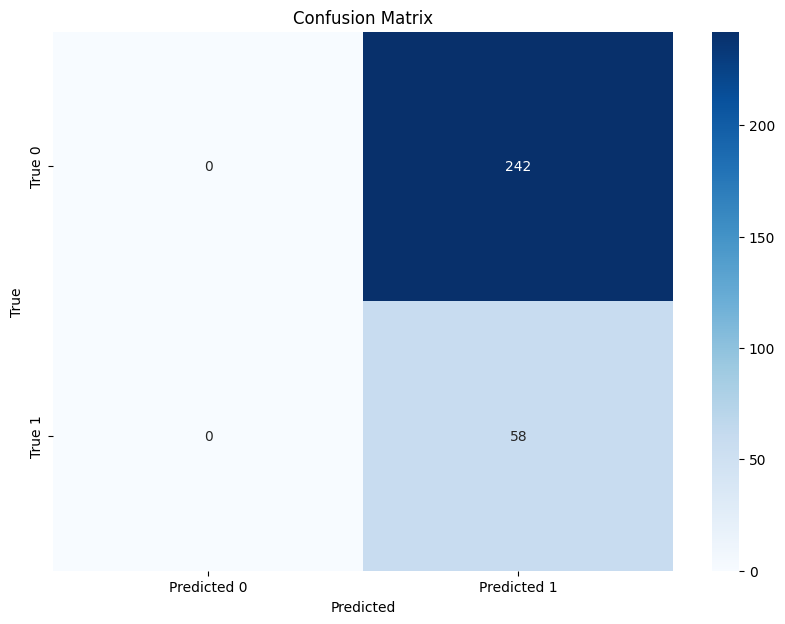

Epoch 0: loss = 0.7903, balanced accuracy = 0.5000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [1] Type: int64
Confusion Matrix:
 [[  0 242]
 [  0  58]]


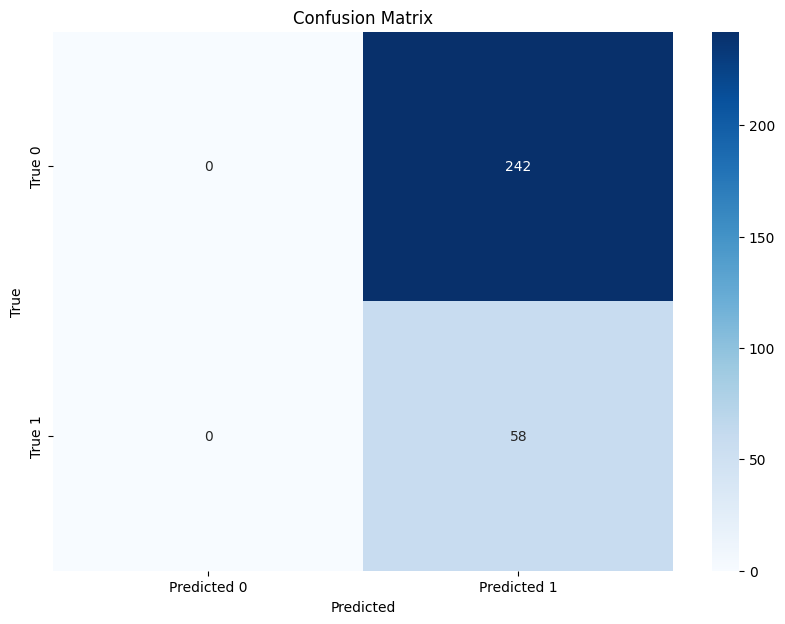

Epoch 1: loss = 0.8353, balanced accuracy = 0.5000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[198  44]
 [  3  55]]


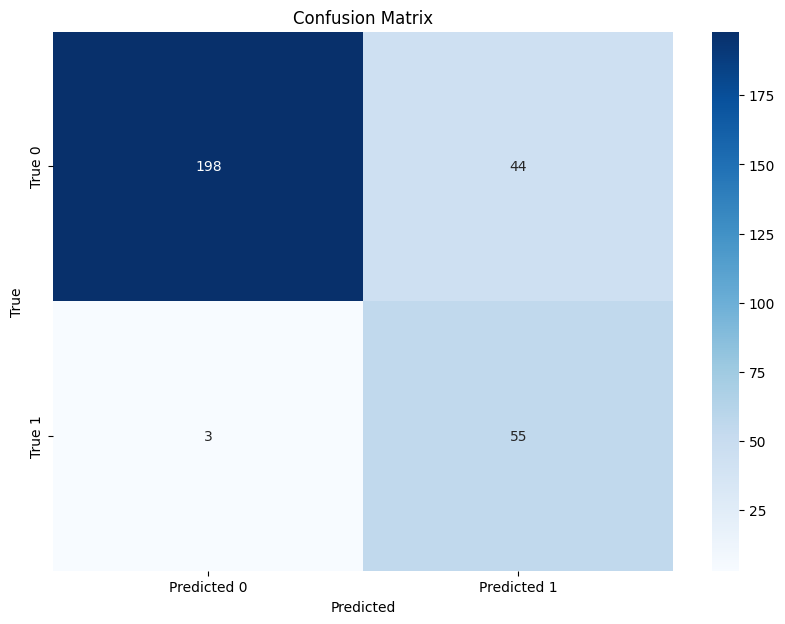

Epoch 2: loss = 0.6128, balanced accuracy = 0.8832


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[178  64]
 [  0  58]]


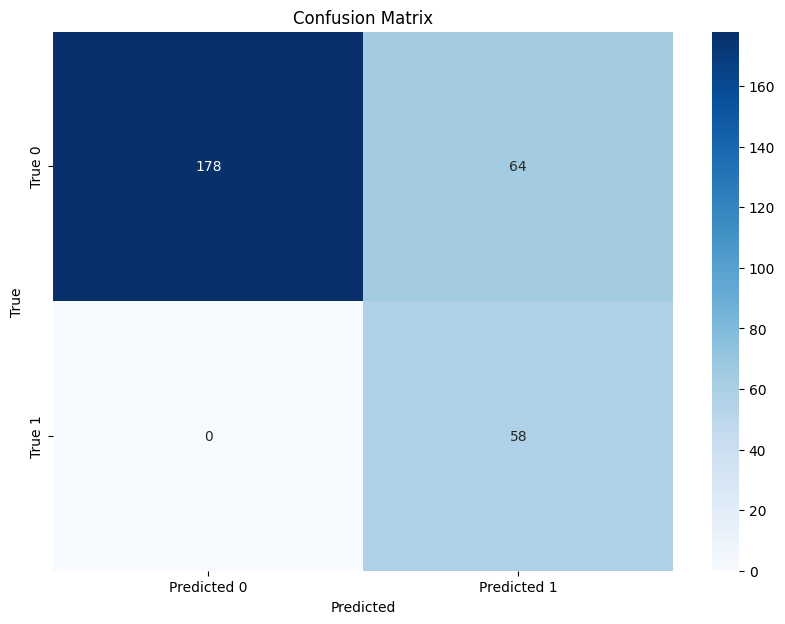

Epoch 3: loss = 0.6110, balanced accuracy = 0.8678


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[215  27]
 [ 12  46]]


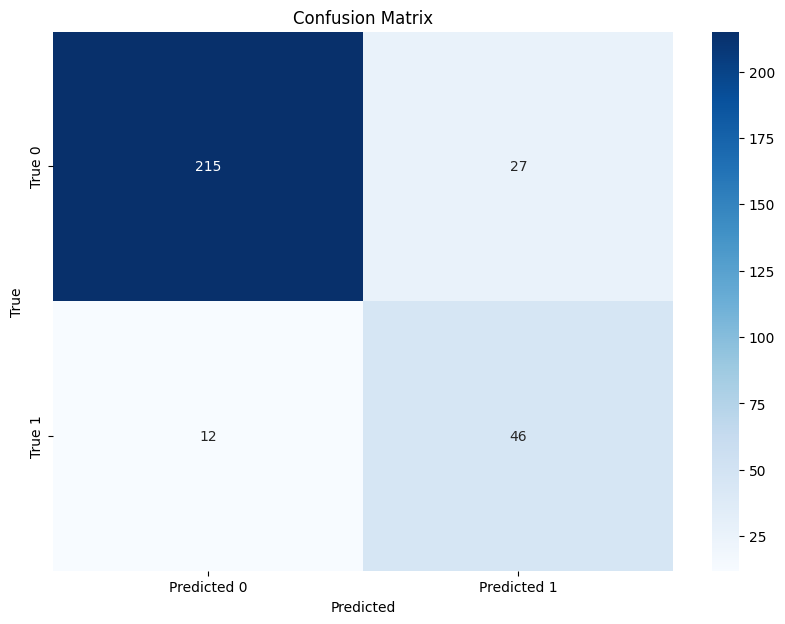

Epoch 4: loss = 0.5501, balanced accuracy = 0.8408


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[188  54]
 [  1  57]]


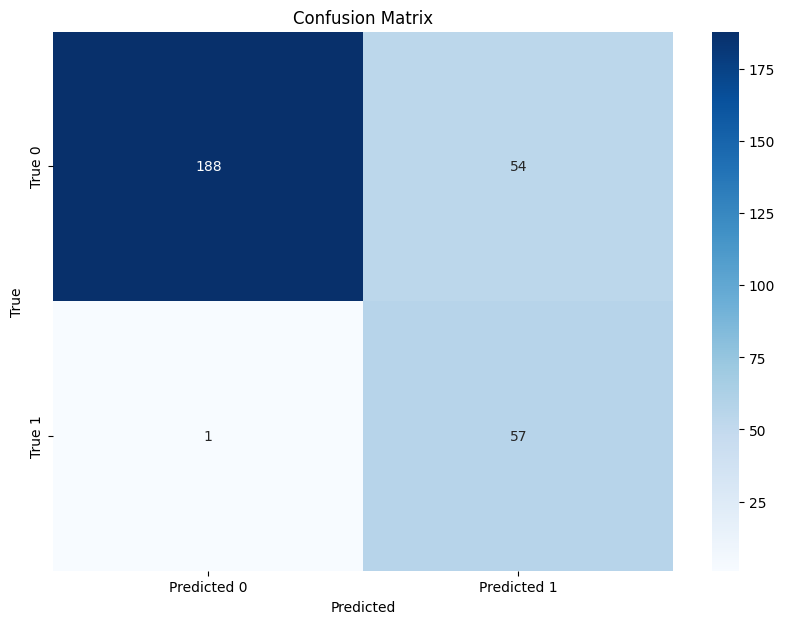

Epoch 5: loss = 0.5746, balanced accuracy = 0.8798


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[158  84]
 [  0  58]]


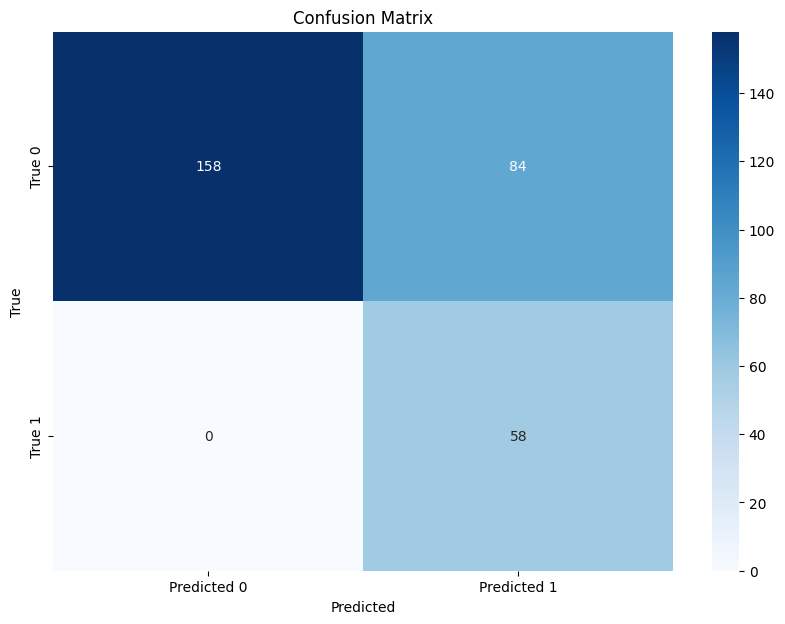

Epoch 6: loss = 0.6054, balanced accuracy = 0.8264


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[204  38]
 [  6  52]]


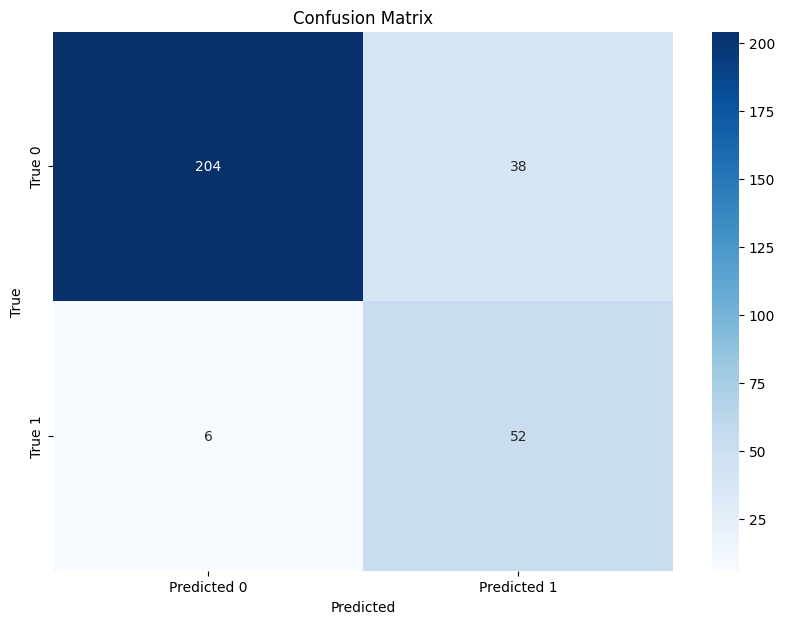

Epoch 7: loss = 0.4624, balanced accuracy = 0.8698


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[226  16]
 [ 26  32]]


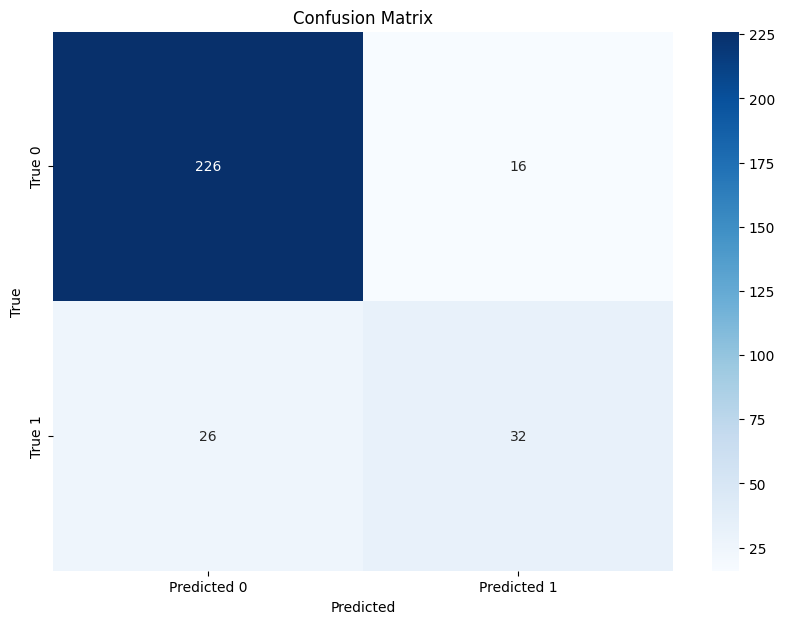

Epoch 8: loss = 0.3770, balanced accuracy = 0.7428


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[226  16]
 [ 24  34]]


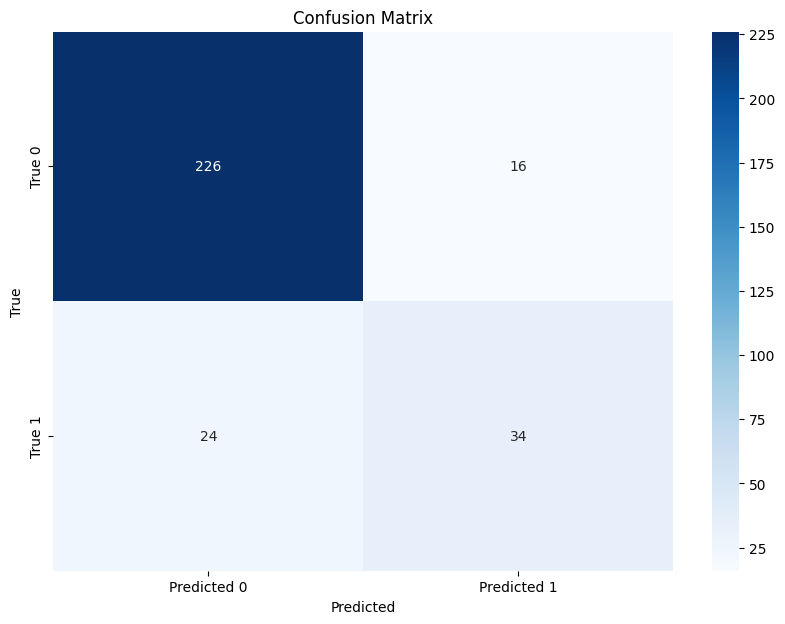

Epoch 9: loss = 0.3858, balanced accuracy = 0.7600


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[208  34]
 [  7  51]]


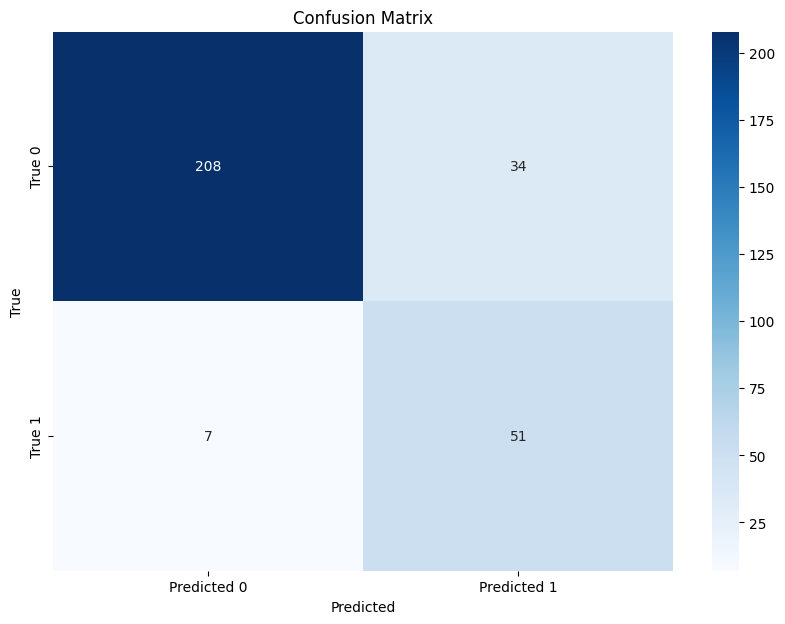

Epoch 10: loss = 0.4215, balanced accuracy = 0.8694


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[196  46]
 [  2  56]]


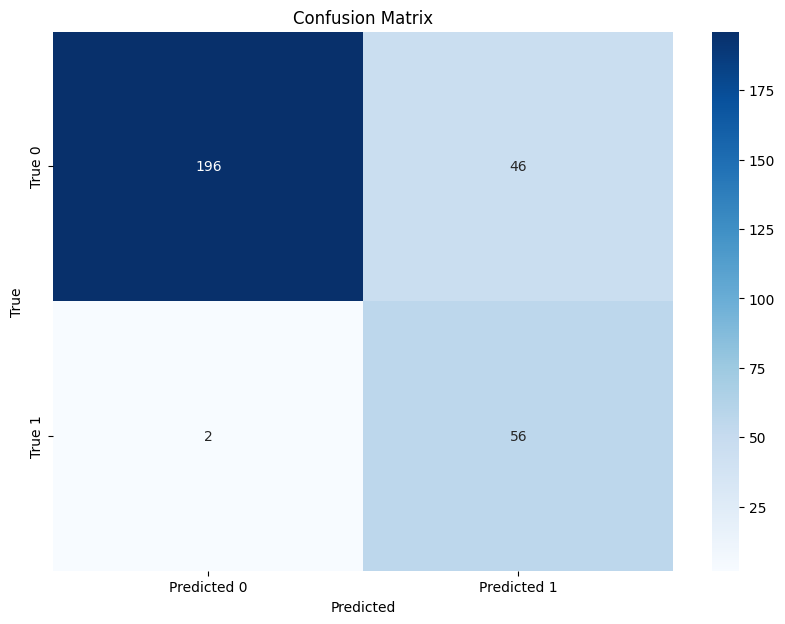

Epoch 11: loss = 0.4611, balanced accuracy = 0.8877


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[208  34]
 [  5  53]]


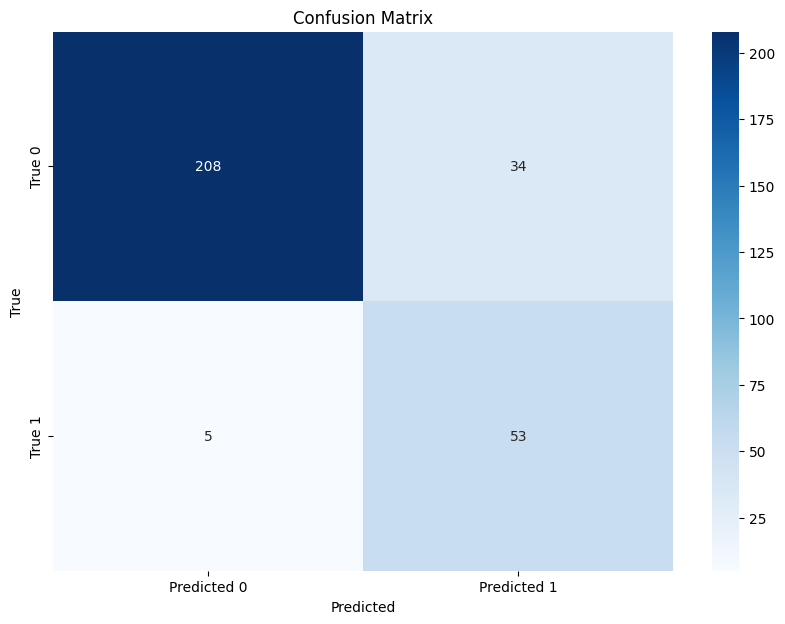

Epoch 12: loss = 0.3945, balanced accuracy = 0.8866


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[220  22]
 [ 14  44]]


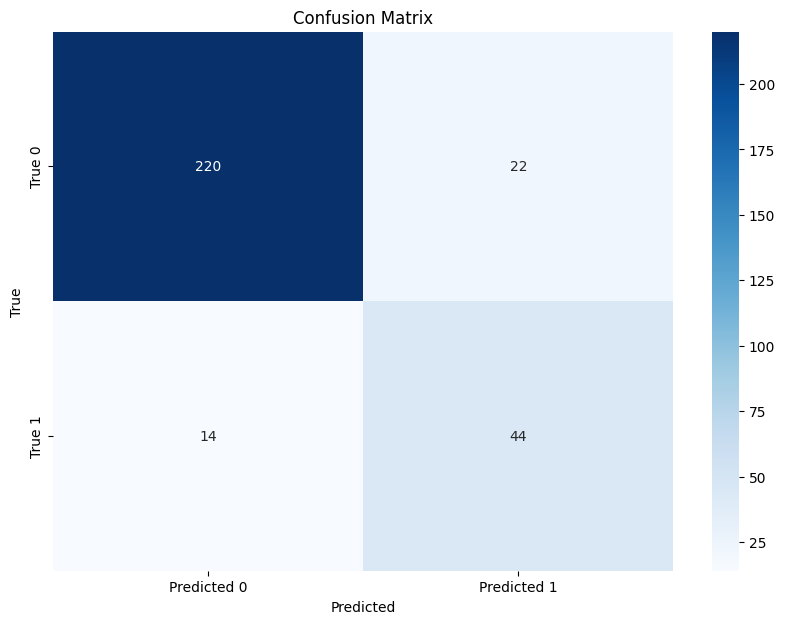

Epoch 13: loss = 0.3294, balanced accuracy = 0.8339


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[224  18]
 [ 21  37]]


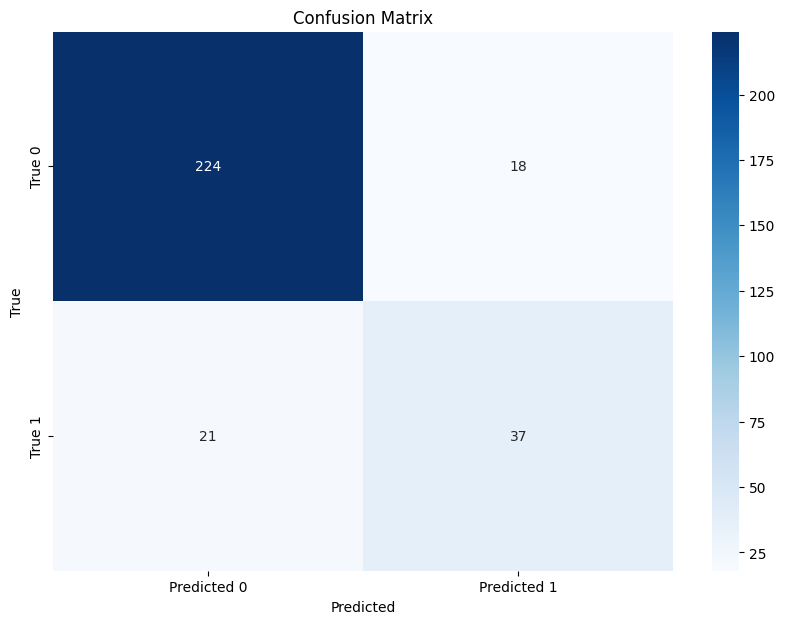

Epoch 14: loss = 0.2718, balanced accuracy = 0.7818


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[57  5]
 [ 4 11]]


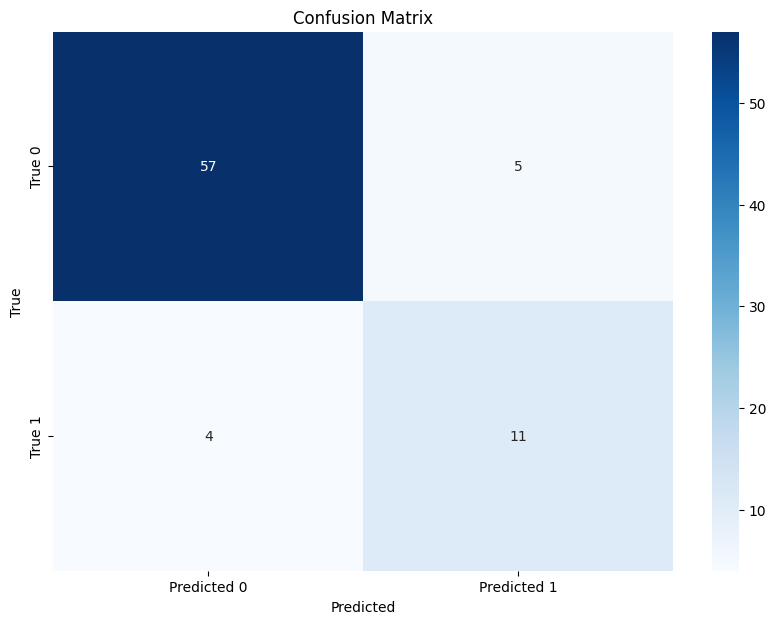

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[224  18]
 [ 21  37]]


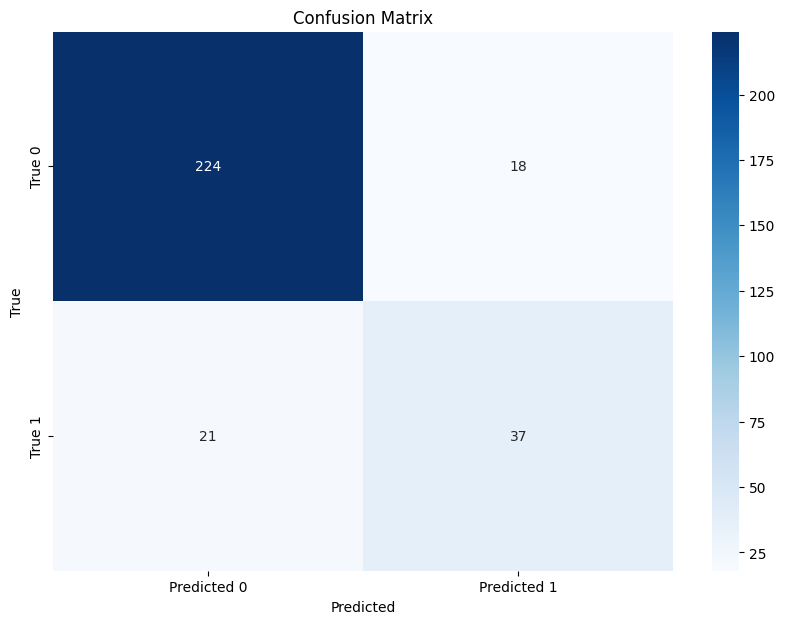

{'accuracy': 0.8831168831168831, 'sensitivity': 0.7333333333333333, 'specificity': 0.9193548387096774, 'balanced_accuracy': 0.8263440860215053, 'confusion_matrix': array([[57,  5],
       [ 4, 11]]), 'mean_loss': 0.2988287969069047}
{'accuracy': 0.87, 'sensitivity': 0.6379310344827587, 'specificity': 0.9256198347107438, 'balanced_accuracy': 0.7817754345967513, 'confusion_matrix': array([[224,  18],
       [ 21,  37]]), 'mean_loss': 0.2717551210522652}


In [ ]:
image_directory = path.join('OASIS-1_dataset', 'CAPS')
list_transforms = CropRightHippoCampus(2)

train_RightHippoCampus = ds_MRI(image_directory, ds_train, list_transforms=list_transforms)
test_RightHippoCampus = ds_MRI(image_directory, ds_test, list_transforms=list_transforms)

learning_rate = 5e-6
n_epochs = 20
batch_size = 4

# Put the network on GPU
model_RightHippoCampus = DenseNet3D().cuda()
trainloader_RightHC = DataLoader(train_RightHippoCampus, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
testloader_RightHC = DataLoader(test_RightHippoCampus, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model_RightHippoCampus.parameters(), learning_rate)

bestmodel_RightHippoCampus = train(model_RightHippoCampus, trainloader_RightHC, criterion, optimizer, n_epochs)

testresults_RightHCdf, testmetrics_RightHC = test(bestmodel_RightHippoCampus, testloader_RightHC, criterion)
trainresults_RightHCdf, trainmetrics_RightHC = test(bestmodel_RightHippoCampus, trainloader_RightHC, criterion)

print(testmetrics_RightHC)
print(trainmetrics_RightHC)

In [ ]:
valid_early=[0,1,5,6,9,10,11,14]
valid_late=[2,3,4,7,8,12,13]
count_early=0
count_late=0
total_early=len(valid_early)
total_late=len(valid_late)
print(total_early,total_late)

for iii in range (np.size(valid_early)):
  if (testresults_RightHCdf.true_label[valid_early[iii]] == testresults_RightHCdf.predicted_label[valid_early[iii]]):
    count_early=count_early+1

for iii in range (np.size(valid_late)):
  if (testresults_RightHCdf.true_label[valid_late[iii]] == testresults_RightHCdf.predicted_label[valid_late[iii]]):
    count_late=count_late+1

print(count_early,count_late)
print("Accuracy of very mild alzheimer on validation dataset=",count_early/total_early)
print("Accuracy of moderate alzheimer on validation dataset=",count_late/total_late)
print("Balanced accuracy of alzheimer=",(count_early/total_early+count_late/total_late)/2 )

8 7
5 6
Accuracy of very mild alzheimer on validation dataset= 0.625
Accuracy of moderate alzheimer on validation dataset= 0.8571428571428571
Balanced accuracy of alzheimer= 0.7410714285714286


In [ ]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score

trues=np.array(trainresults_RightHCdf.true_label[:],dtype=int)
preds=np.array(trainresults_RightHCdf.predicted_label[:],dtype=int)
bal_acc=balanced_accuracy_score(trues,preds)
print("balanced accy of training full", bal_acc)
roc_aucs=roc_auc_score(trues,preds)
print("rocs of training full",roc_aucs)

trues_t=np.array(testresults_RightHCdf.true_label[:],dtype=int)
preds_t=np.array(testresults_RightHCdf.predicted_label[:],dtype=int)
bal_acc_t=balanced_accuracy_score(trues_t,preds_t)
print("balanced accy of testing full", bal_acc_t)
roc_aucs_t=roc_auc_score(trues_t,preds_t)
print("rocs of testing full",roc_aucs_t)

balanced accy of training full 0.7817754345967513
rocs of training full 0.7817754345967513
balanced accy of testing full 0.8263440860215053
rocs of testing full 0.8263440860215053
